In [1]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd


%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4)

#### Here we reproduce the results from *Identifying and Correcting Label Bias in Machine Learning* 
[\[Jiang and Nachum 2019\]](https://arxiv.org/pdf/1901.04966.pdf)

The code from the authors could be found [here](https://github.com/google-research/google-research/blob/master/label_bias/)

In [2]:
from fairness import plot_confusion_matrix, fairness_violation, reweigth_samples
from get_data import get_adult

In [3]:
X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=42)

(48842, 15)


In [4]:
from sklearn.linear_model import LogisticRegression
lr = SGDClassifier(loss="log", penalty="l2", alpha=5e-4,
                   validation_fraction=0.2, random_state=0,
                   early_stopping=True, n_iter_no_change=5, tol=1e-3)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Error on test set =', 1-lr.score(X_test, y_test))

NameError: name 'SGDClassifier' is not defined

## 1. Fairness 

There is severals way to define the fairness. 
Here we highlight two kind of fairness:
1. **Demographic parity** [Dwork et al., 2012]() A fair classifier should make positive predictions on protected groups at the same rate as on all of X
2. **Equal opportunity** [Hardt et al., 2016]() A fair classifier should have equal true positive rates on protected groups at the same rate as on all of X

Now if we want to check if the predictions of our model is fair with respect to the protected group, let's examine the confusion matrix for both the protected group and every samples X.

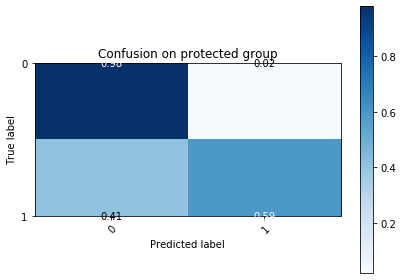

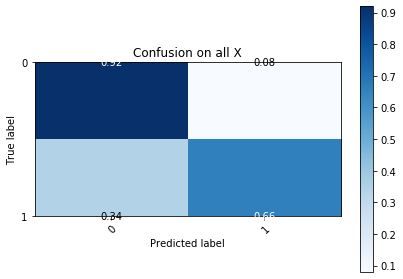

In [58]:
plot_confusion_matrix(y_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X')

With the confusion matrix, we clearly see that the **True Positive Rate** on the protected group (of 0.55) is **lower** than on all X (0.61).  
So our classifier is bias w.r.t. the protected group. That violate the *Equal opportunity* fairness.  

Also the **positive predictions** are **higher** in X all than on the protected group. That violate *the Demographic parity* fairness.

In [59]:
### STD for CM
from sklearn.metrics import confusion_matrix

l_cm_protected, l_cm = [], []

for random_state in range(10):
    X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=random_state)
    
    lr = LogisticRegression(solver='lbfgs', max_iter=500)
    lr.fit(X_train, y_train)
#     print('Error on test set =', 1-lr.score(X_test, y_test))
    y_pred = lr.predict(X_test)

    cm_protected = confusion_matrix(y_test[protected_test], y_pred[protected_test])
    cm_protected = cm_protected.astype('float') / cm_protected.sum(axis=1)[:, np.newaxis]
    l_cm_protected.append(cm_protected)
    
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    l_cm.append(cm)
    
print('STD for cm_protected :\n', np.asarray(l_cm_protected).std(axis=0))
print('STD for cm:\n', np.asarray(l_cm).std(axis=0))

STD for cm_protected :
 [[0.0025 0.0025]
 [0.0215 0.0215]]
STD for cm:
 [[0.0029 0.0029]
 [0.0086 0.0086]]


## 2. Correct the fairness violation by reweighting / sample_weight

In [60]:
from sklearn.linear_model import SGDClassifier

In [ ]:
# fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

lambda: -1.000000, train violation: -0.295212, test violation: -0.285024
lambda: -0.785714, train violation: -0.255583, test violation: -0.268859
lambda: -0.571429, train violation: -0.214772, test violation: -0.235590
lambda: -0.357143, train violation: -0.171255, test violation: -0.197935
lambda: -0.142857, train violation: -0.134410, test violation: -0.156584
lambda: 0.071429, train violation: -0.096190, test violation: -0.107025
lambda: 0.285714, train violation: -0.059992, test violation: -0.071908
lambda: 0.500000, train violation: -0.020248, test violation: -0.046377
lambda: 0.714286, train violation: 0.010277, test violation: -0.008597
lambda: 0.928571, train violation: 0.056612, test violation: 0.018782
lambda: 1.142857, train violation: 0.090753, test violation: 0.061292
lambda: 1.357143, train violation: 0.121733, test violation: 0.095595
lambda: 1.571429, train violation: 0.146848, test violation: 0.124698
lambda: 1.785714, train violation: 0.165827, test violation: 0.15624

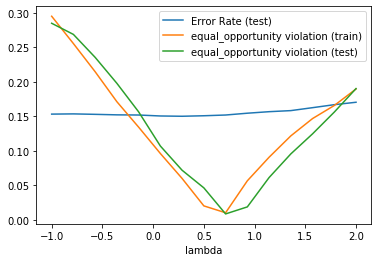

In [67]:
%%time
# def get_lambda_star():

criterion = "equal_opportunity"
lambda_ = 0
lr = LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-1)
lr = SGDClassifier(loss="log", penalty="l2", alpha=5e-4,
                   validation_fraction=0.2, random_state=0,
                   early_stopping=True, n_iter_no_change=5, tol=1e-3)

l_lambda = []
l_delta = []
l_score_test_err = []
l_fairness_violation = []
for t in np.linspace(-1, 2, 15):  # range(100): #2.507586
    lambda_ = t
    l_lambda.append(lambda_)
    w = reweigth_samples(lambda_, protected_train, y_train)
    lr.fit(X_train, y_train, sample_weight=w)

    train_violation = fairness_violation(
        lr.predict(X_train), y_train,
        protected_train, notion=criterion)
    l_delta.append(train_violation)

    l_score_test_err.append(1-lr.score(X_test, y_test))
    test_violation = fairness_violation(lr.predict(X_test), y_test,
                                        protected_test, notion=criterion)
    l_fairness_violation.append(test_violation)
    print(f"lambda: {lambda_:.6f}, "
          f"train violation: {train_violation:.6f}, "
          f"test violation: {test_violation:.6f}")

#     lambda_ = lambda_ - train_violation
    
#     if abs(train_violation) < 1e-2:
#         break
    
plt.plot(l_lambda, l_score_test_err, label='Error Rate (test)')
plt.plot(l_lambda, np.abs(l_delta),
         label='%s violation (train)' % criterion)
plt.plot(l_lambda, np.abs(l_fairness_violation),
         label='%s violation (test)' % criterion)
plt.xlabel('lambda')
plt.legend()

Error on test set = 0.14519695356645645


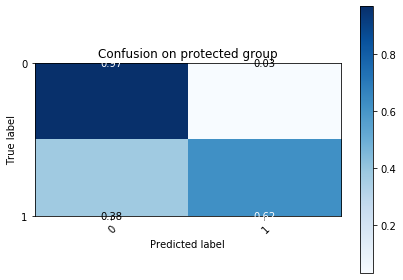

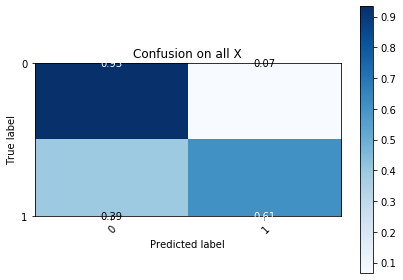

In [63]:
w = reweigth_samples(lambda_, protected_train, y_train)
lr.fit(X_train, y_train, sample_weight=w)
print('Error on test set =', 1-lr.score(X_test, y_test))
y_pred = lr.predict(X_test)
plot_confusion_matrix(y_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X');

- TPR looks more the same -> Better fairness yeah \o/

In [64]:
## STD for plot

ll_fair, ll_score = [], []
for random_state in range(10):
    print(random_state)
    X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=random_state)
    
    lambda_ = 0
    lr = LogisticRegression(solver='lbfgs', max_iter=500)
    lr.fit(X_train, y_train)

    l_lambda = []
    l_delta = []
    l_score_test_err = []
    l_fairness_violation = []
    for t in np.linspace(-2,7, 15):  # range(100): #2.507586
        print(int(t), end=' ')
    #     delta = fairness_violation(lr.predict(X_train), y_train,
    #                                protected_train, notion='demographic_parity')
    #     l_delta.append(delta)
    #     lambda_ = lambda_ - delta
        lambda_ = t
        l_lambda.append(lambda_)
        w = reweigth_samples(lambda_, protected_train, y_train)
        lr.fit(X_train, y_train, sample_weight=w)
        l_score_test_err.append(1-lr.score(X_test, y_test))
        l_fairness_violation.append(fairness_violation(lr.predict(X_test), y_test,
                                   protected_test, notion='demographic_parity')) # demographic_parity #equal_opportunity
        
    ll_fair.append(l_fairness_violation)
    ll_score.append(l_score_test_err)
    
plt.errorbar(l_lambda, np.mean(ll_score, axis=0), yerr=np.std(ll_score, axis=0), label = 'Error Rate')
plt.errorbar(l_lambda, np.mean(np.abs(ll_fair), axis=0), yerr=np.std(np.abs(ll_fair), axis=0), label = 'Fairness Violation')
plt.xlabel('lambda')
plt.legend()

0
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 1
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 2
-2 

KeyboardInterrupt: 

## 3. With generated data
Here we could have access to `y_true` and `y_bias`

In [130]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

def get_generated_rnd_data(n_samples=20000, random_state=1):
    # generate toy data    
    
    np.random.seed(random_state)
    X, y_true = make_classification(n_samples=int(n_samples),
                                    random_state=random_state, n_features=4) 
    protected_group = X[:,0] > 0 
    
    y_bias = y_true.copy()
    for i in range(len(X)):
        if protected_group[i]:
            if y_true[i]:
                y_bias[i] = np.random.binomial(1, .7)

    #y_bias[y_true[protected_group]>0] = np.random.binomial(1, .7,
    #                                            size = sum(y_true[protected_group]>0))

    return train_test_split(X, y_true, y_bias,
                            protected_group,
                            random_state=random_state)
    


def get_generated_bias_data(n_samples=20000, lambda0 = 1.7, random_state=1):
    # generate y_bias according to P.1. 
    
    np.random.seed(random_state)
    X, y_true = make_classification(n_samples=n_samples,
                                    random_state=random_state, n_features=20) 
    protected_group = X[:,0] > 0 
    ratio_pg = np.sum(protected_group) / len(y_true)
    
    y_bias = y_true.copy()
    y_bias = y_true * np.exp(-lambda0 * (y_true * (protected_group/ ratio_pg - 1)))
    y_bias /= max(y_bias)
    
    y_obs = np.random.binomial(1, y_bias, len(y_bias))
    return train_test_split(X, y_true, y_obs,
                            protected_group,
                            random_state=random_state)

# X = np.random.uniform(-1, 1, size=(500,2))
# y_true = X[:,1] > 0
# pg = X[:,0] < -.7
# y_bias = y_true.copy()
# for i in range(len(X)):
#     if pg[i]:
#         if y_true[i]:
#             y_bias[i] = np.random.binomial(1, .7)
            
    
X_train, X_test,\
y_true_train, y_true_test,\
y_bias_train, y_bias_test,\
protected_train, protected_test = get_generated_bias_data(lambda0=1.2)
# protected_train, protected_test = get_generated_rnd_data()
# get_generated_bias_data(lambda0 = .5)
# .5 -> lambda = 2.64

y_train, y_test = y_bias_train, y_bias_test

In [131]:
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train, y_bias_train)
print('Error on bias test set =', 1-lr.score(X_test, y_bias_test))
print('Error on TRUE test set =', 1-lr.score(X_test, y_true_test))
y_pred = lr.predict(X_test)

Error on bias test set = 0.15080000000000005
Error on TRUE test set = 0.3084


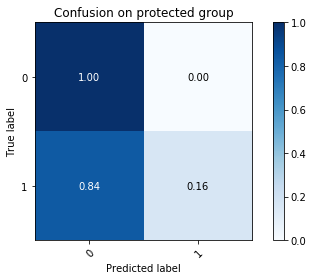

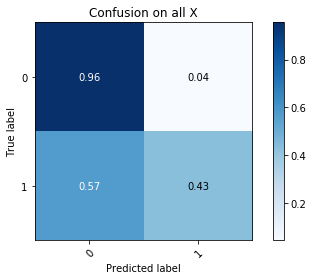

In [132]:
plot_confusion_matrix(y_true_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_true_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X')

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 
Error Oracle =	 0.07299999999999995
lambda_star 4.356060606060606
Error on bias test =	 0.26080000000000003
Error on TRUE test =	 0.07399999999999995
[0.0, 0.01893939393939394, 0.03787878787878788]
[4.962121212121212, 4.981060606060606, 5.0]


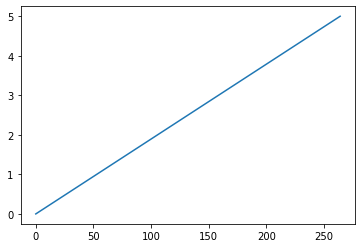

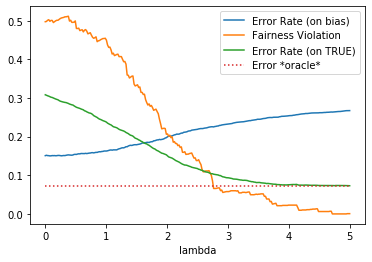

In [133]:
#### with generated

fairness_notion = 'equal_opportunity'
lambda_ = 1
lr = LogisticRegression(solver='lbfgs', max_iter=400)
lr.fit(X_train, y_train)

l_lambda = []
l_delta = []
l_score_test_err = []
l_score_true_err = []
l_fairness_violation = []
for it, t in enumerate(np.linspace(0,5, 265)): #-1,4
    if it%10==0:
        print(int(it), end=' ')
    delta = fairness_violation(lr.predict(X_train), y_train,
                               protected_train, notion=fairness_notion)
    l_delta.append(delta)
#     lambda_ = lambda_ - delta
    lambda_ = t
    l_lambda.append(lambda_)
    w = reweigth_samples(lambda_, protected_train, y_train)
    lr.fit(X_train, y_train, sample_weight=w)
    l_score_test_err.append(1-lr.score(X_test, y_bias_test))
    l_score_true_err.append(1-lr.score(X_test, y_true_test))
    l_fairness_violation.append(fairness_violation(lr.predict(X_test), y_test,
                               protected_test, notion=fairness_notion))


    
## 
print()
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train, y_true_train)
err_oracle = 1-lr.score(X_test, y_true_test)
print('Error Oracle =\t', err_oracle)
y_pred_oracle = lr.predict(X_test)

lambda_star = l_lambda[np.argmin(np.abs(l_delta))]
print('lambda_star', lambda_star)
w_star = reweigth_samples(lambda_star, protected_train, y_train)
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train, y_bias_train, sample_weight=w_star)
print('Error on bias test =\t', 1-lr.score(X_test, y_bias_test))
print('Error on TRUE test =\t', 1-lr.score(X_test, y_true_test))
y_pred = lr.predict(X_test)


plt.plot(l_lambda)
print(l_lambda[:3])
print(l_lambda[-3:])
plt.figure()
plt.plot(l_lambda, l_score_test_err, label = 'Error Rate (on bias)')
plt.plot(l_lambda, np.abs(l_fairness_violation), label = 'Fairness Violation')
plt.plot(l_lambda, l_score_true_err, label = 'Error Rate (on TRUE)')
plt.plot(l_lambda, [err_oracle] * len(l_lambda), ':', label='Error *oracle*')
plt.xlabel('lambda')
plt.legend()

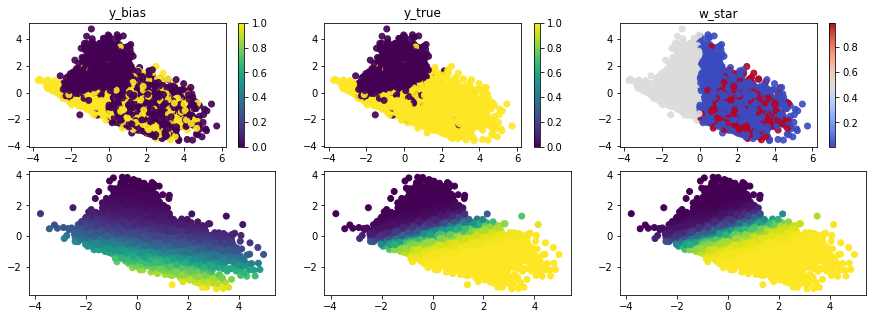

In [120]:
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
plt.title('y_bias')
plt.scatter(X_train[:,0], X_train[:,1], c=y_bias_train, alpha=.9)
plt.colorbar()
plt.subplot(2,3,2)
plt.title('y_true')
plt.scatter(X_train[:,0], X_train[:,1], c=y_true_train, alpha=.9)
plt.colorbar()
plt.subplot(2,3,4)
lr = LogisticRegression(solver='lbfgs', max_iter=400)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=lr.predict_proba(X_test)[:,1])
plt.subplot(2,3,5)
lr = LogisticRegression(solver='lbfgs', max_iter=400)
lr.fit(X_train, y_true_train)
y_pred = lr.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=lr.predict_proba(X_test)[:,1])

plt.subplot(2,3,3)
plt.title('w_star')
plt.scatter(X_train[:,0], X_train[:,1], c=w_star, cmap='coolwarm', alpha=.9)
plt.colorbar()
plt.subplot(2,3,6)
lr = LogisticRegression(solver='lbfgs', max_iter=400)
lr.fit(X_train, y_train, sample_weight=w_star)
y_pred = lr.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=lr.predict_proba(X_test)[:,1])

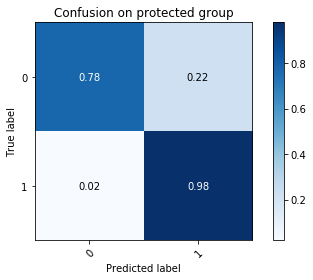

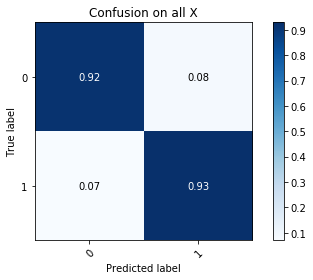

In [117]:
plot_confusion_matrix(y_true_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_true_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X')

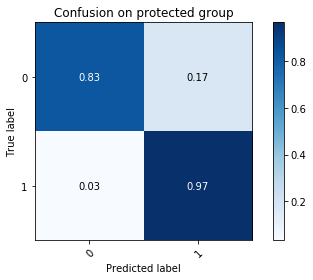

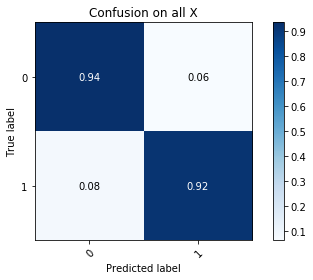

In [118]:
plot_confusion_matrix(y_true_test[protected_test], y_pred_oracle[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_true_test, y_pred_oracle, ['0', '1'], normalize=True, title='Confusion on all X')